In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp

In [ ]:
class body:
    class cylinder:
        def __init__(self, radius, length):
            pass
    class cuboidal_beam:
        def __init__(self, geometry:np.ndarray):
            self.length = geometry[0]
            self.breadth = geometry[1]
            self.lbcons = geometry[2]
            self.constraint = geometry[3]
            if self.constraint == 'lb':
                self.lbcons()
        def lbcons():
            pass
        
    def __init__(self, type:str, geom:np.ndarray, load: np.ndarray, mat:np.ndarray):
        self.type = type
        if self.type == 'cubbeam':
            self.body = self.cuboidal_beam(geom)
        if load[0] =='ax':
            
        pass

class FE:
    def __init__(self, loc:np.ndarray):
        self.pos = loc
        self.state = [] 

In [31]:
class Material:
    def __init__(self, E:float, nu:float, rho:float):
        self.E = E 
        self.rho = rho
        self.nu = nu
        self.G = E / (2 * (1 + nu))

# class Beam:
#     def __init__(self, face_geom:np.ndarray):
#         if face_geom=='Rect':
#             return self.CuboidalBeam
class CuboidalBeam:
    def __init__(self, length:float, breadth:float, width:float):
        self.length = length
        self.breadth = breadth
        self.width = width
        self.facearea = breadth*width

    def constraint(self, constype: str = 'fixed', location: float = 'left'):
        """
        constype: 'fixed'
        location: 'left', 'right'
        """
        self.cons = [constype, location]

# class Load:
#     def __init__(self, loadtype: 'str', magnitude: float, location: float):
#         pass
#     pass

class AxialLoad:
    def __init__(self, value: float, location: float):
        '''Assume x along length, and give location in terms of x'''
        self.load = [value, location]
    pass

class Body:
    def __init__(self, material:Material, geometry:CuboidalBeam, load:AxialLoad, *args):
        self.material = material
        self.geometry = geometry
        self.load = load
        self.results = {}
        if isinstance(load, AxialLoad):
            self.axl()
    
    def axl(self,):
        # calc sigma_xx
        x = np.linspace(0, self.geometry.length, 100)
        if self.geometry.cons[1] == 'left':
            reaction = np.piecewise(
                x, 
                [(x>=0) & (x<=float(self.load.load[1]))], 
                [self.load.load[0]])

        if self.geometry.cons[1] == 'right':
            reaction = np.piecewise(
                x, 
                [(x >= float(self.load.load[1])) & (x <= float(self.geometry.length))], 
                [self.load.load[0]])
        
        axial_stress = reaction/(self.geometry.facearea)
        
        self.results['x'] = x
        self.results['axial_stress'] = axial_stress
        self.results['internal_force'] = reaction
    
    def plot_result(self,):
        if not self.results:
            raise ValueError("No results to plot. Run analysis first.")
        
        fig, axes = plt.subplots(2, 1, figsize=(10, 10))
        
        # Stress plot
        axes[0].plot(self.results['x'], self.results['axial_stress'] / 1e6, 'b-', linewidth=2)
        axes[0].set_xlabel('Position along beam (m)')
        axes[0].set_ylabel('Axial Stress (MPa)')
        axes[0].set_title('Axial Stress Distribution')
        axes[0].grid(True, alpha=0.3)
        # Internal force plot
        axes[1].plot(self.results['x'], self.results['internal_force'], 'r-', linewidth=2)
        axes[1].set_xlabel('Position along beam (m)')
        axes[1].set_ylabel('Internal Force (N)')
        axes[1].set_title('Internal Force Distribution')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    def print_results(self,):
        if not self.results:
            raise ValueError("No results to print. Run analysis first.")
        # print()
# class BoundaryConditions:
#     pass

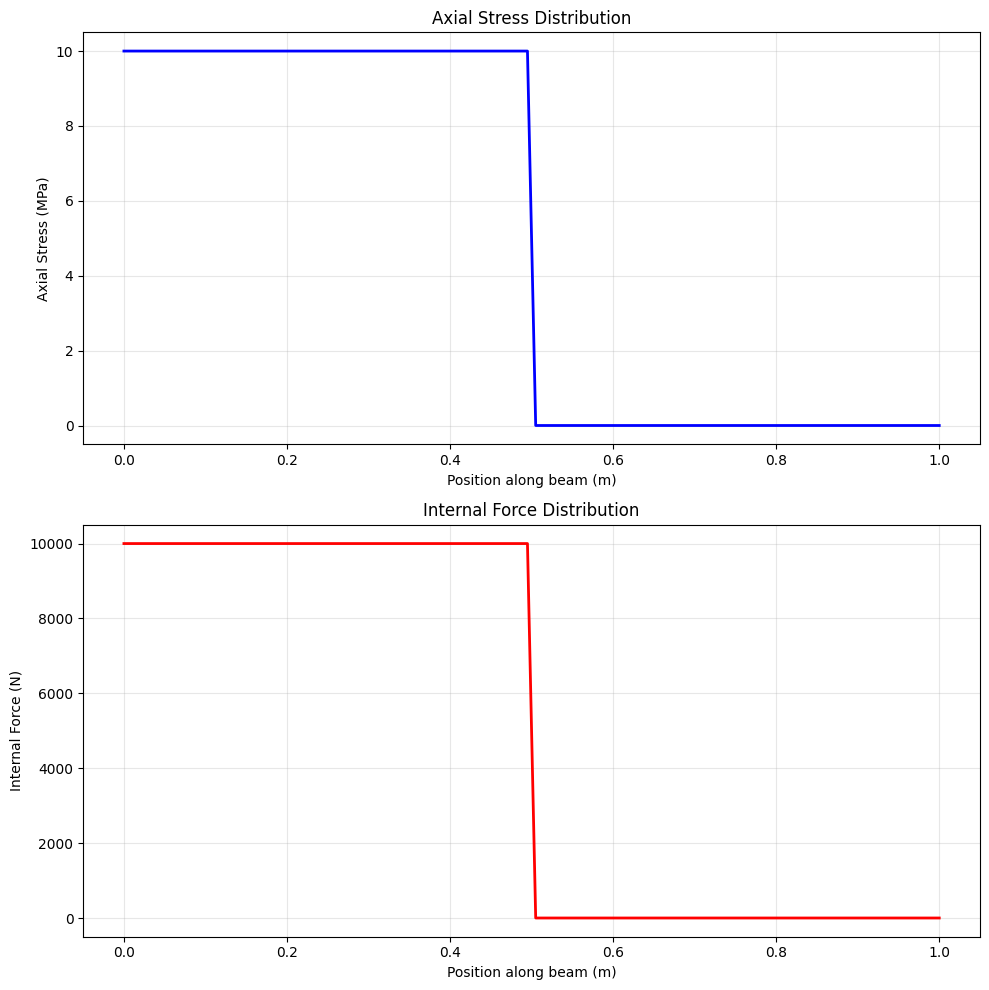

In [32]:
# Define material (Steel)
steel = Material(E=200e9, nu=0.3, rho=7850)

# Define geometry
beam = CuboidalBeam(length=1.0, breadth=0.05, width=0.02)
beam.constraint(constype='fixed', location='left')

# Define load
load = AxialLoad(value=10000, location=0.5)  # 10 kN tension

# Create body and analyze
body = Body(material=steel, geometry=beam, load=load)

# Print summary
# body.print_summary()

# Plot results
body.plot_result()